**Titanic - Machine Learning from Disaster Project**


Variable Definition:
- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)


**Framework**

- **Data Loading.** Quickly examine the dataset to get a picture
- **Exploratory Data Analysis.** Get a thorough understanding of dataset
- **Data Preprocessing.**
- **Feature Engineering.**
- **Model Selection and Evaluation.**

____

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
#tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend 
%matplotlib inline 

# Data Loading

In [2]:
filepath = "../input/titanic/train.csv"
data = pd.read_csv(filepath)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Take a quick look at the dataset

In [3]:
data.shape

(891, 12)

This is a typical small dataset, with only 891 observations and 12 variables.

In [4]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**A series of information can be gained by looking at the info result:**

- Several passengers did not log in their age information, leading to some missing values in age variables.
- More than 70% of observations are missing in Cabin. The enormous amount of missing info implies we might need to drop it from dataset.
- Numerical features include Survived(binary), Pclass(discrete), Sex(binary), Age(continuous), SibSp(binary), Parch(binary), Fare(continuous).
- Categorical features include Cabin, Embarked.

In [6]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Interpretation:**

- The oldest passenger was 80 years old.
- There is a huge range in Fare, with maximal value being 512.3 and the minial value being 0. 0 means that certain passengers did not spend any money on travel. They should be crew of Titanic.

# Exploratory Data Analysis

There are two quesitons we need to inspect when conducting EDA on dataset:

- What type of variation occurs in variables?
- What type of covariation occurs between variables?
____
Framework:
- Understand Varaibles
    - Inspect Missing Observations
    - Inspect Duplication
    - Inspect Outliers
- Variation
- Covariation

## Understand Variables

What variables are numerical features and what variables are categorical features?

In [7]:
s = data.dtypes == "object"
object_cols = data.columns[s].tolist()
object_cols

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

Of these object columns, Sex, Cabin, and Embarked are categorical variables used for segmenting data and needed to be preprocessed before modeling. However, Name and Ticket seems not provide useful information for our predictive modeling.

In [8]:
n = (data.dtypes == "int64") | (data.dtypes == "float64")
numerical_cols = data.columns[n].tolist()
numerical_cols

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

PassengerId needs to be dropped when training model.

In [9]:
# remove passengerId from dataset
numerical_cols.remove("PassengerId")

### Inspect Missing Values

Check how many missing values each variable in the dataset has.

In [10]:
def get_missing_pct(df):
    """compute the percentage for missing val"""
    missing_df = df.apply(lambda col:col.isnull().sum()).to_frame().reset_index().rename(columns={"index":"column",0:"missing_cnt"})
    IsMissing = missing_df["missing_cnt"]>0
    missing_df_ = missing_df[IsMissing]
    missing_df_["missing_pct"] = missing_df["missing_cnt"] / df.shape[0]
    return missing_df_

In [11]:
miss_data = get_missing_pct(data)
miss_data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,column,missing_cnt,missing_pct
5,Age,177,0.198653
10,Cabin,687,0.771044
11,Embarked,2,0.002245


**Insights:**

- Cabin has more than 70% of observations being missing from the dataset. This implies that we can consider dropping it.
- For Age and Embarked, we can consider imputing missing values with some number or add a new column showing the location of entires of the imputed entries.

In [12]:
data["deck"] = data["Cabin"].str[0]
deck_normalized = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}

def encode_cabin(df):
    df.replace({"deck": deck_normalized}, inplace=True)
    df['deck'].fillna(value=9, inplace=True)        

encode_cabin(data)

In [13]:
data_clean = data.drop("Cabin",axis=1)
data_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,9.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,9.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,9.0


#### Age Missing Examination

Take a closer look at where these missing observations are lcoated.

In [14]:
age_mis_data = data_clean[data_clean.Age.isnull()]
age_mis_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,deck
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,9.0
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,S,9.0
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,C,9.0
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,C,9.0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,Q,9.0


By looking at the dataset, It is obvious that passengers without logging age are from class 3 and do not have spouses/children and parents. Let's visualize these records so we can look at their info in detail.

#### Age Versus Pclass

*Question 1: Does passengers without age informaiton basically are in class 3?*

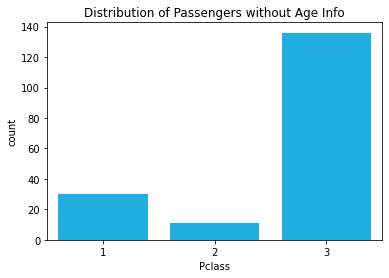

In [15]:
class_mis_data = age_mis_data.groupby("Pclass",as_index=False).agg({"PassengerId":"count"}).rename(columns={"PassengerId":"count"})
sns.barplot(data=class_mis_data,x="Pclass",y="count",color="deepskyblue")
sns.set_style("whitegrid")
plt.title("Distribution of Passengers without Age Info")
plt.show()

Yes, most of passengers without age are those from class 3. If we want to impute the age info for these passengers, we need to know what is the average/median age for the three classes.

*Question 2: What is the distribution of age across the three cabins?*

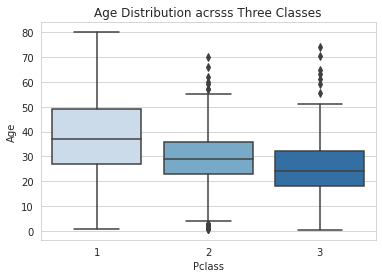

In [16]:
sns.boxplot(data=data_clean,x="Pclass",y="Age",palette="Blues")
plt.title("Age Distribution acrsss Three Classes")
plt.show()

**Interpretation:**

- Richer people from top class tend to be older
    - Passengers in first class tend to be around 37 years old.
    - Passengers in second class tend to be around 29 years old.
    - Passengers in the third class tend to be centered around 24 years old.
    
I decided to use the insights to fill missing values of age.

In [17]:
def fill_age(ser):
    if np.isnan(ser.loc["Age"]) and ser.loc["Pclass"] == 1:
        return 37
    elif np.isnan(ser.loc["Age"]) and ser.loc["Pclass"] == 2:
        return 29
    elif np.isnan(ser.loc["Age"]) and ser.loc["Pclass"] == 3:
        return 24
    else:
        return ser.loc["Age"]

data_clean["Age"] = data_clean.apply(lambda row:fill_age(row),axis=1)

### Inspect Duplicated Values

It is obvious that each PassengerId is the primary key for the dataset, so we can use it to check whether there is any duplicated record in the dataset.

In [18]:
dup_data = data_clean.duplicated(subset="PassengerId").astype("int").sum()
dup_data

0

The result shows that there is no duplicated record in the dataset. We move on to the examniation of outliers.

## Variation

### Distribution of Variables

Plotting the distribution of variables to find out frequent values, less-common values, and outliers.

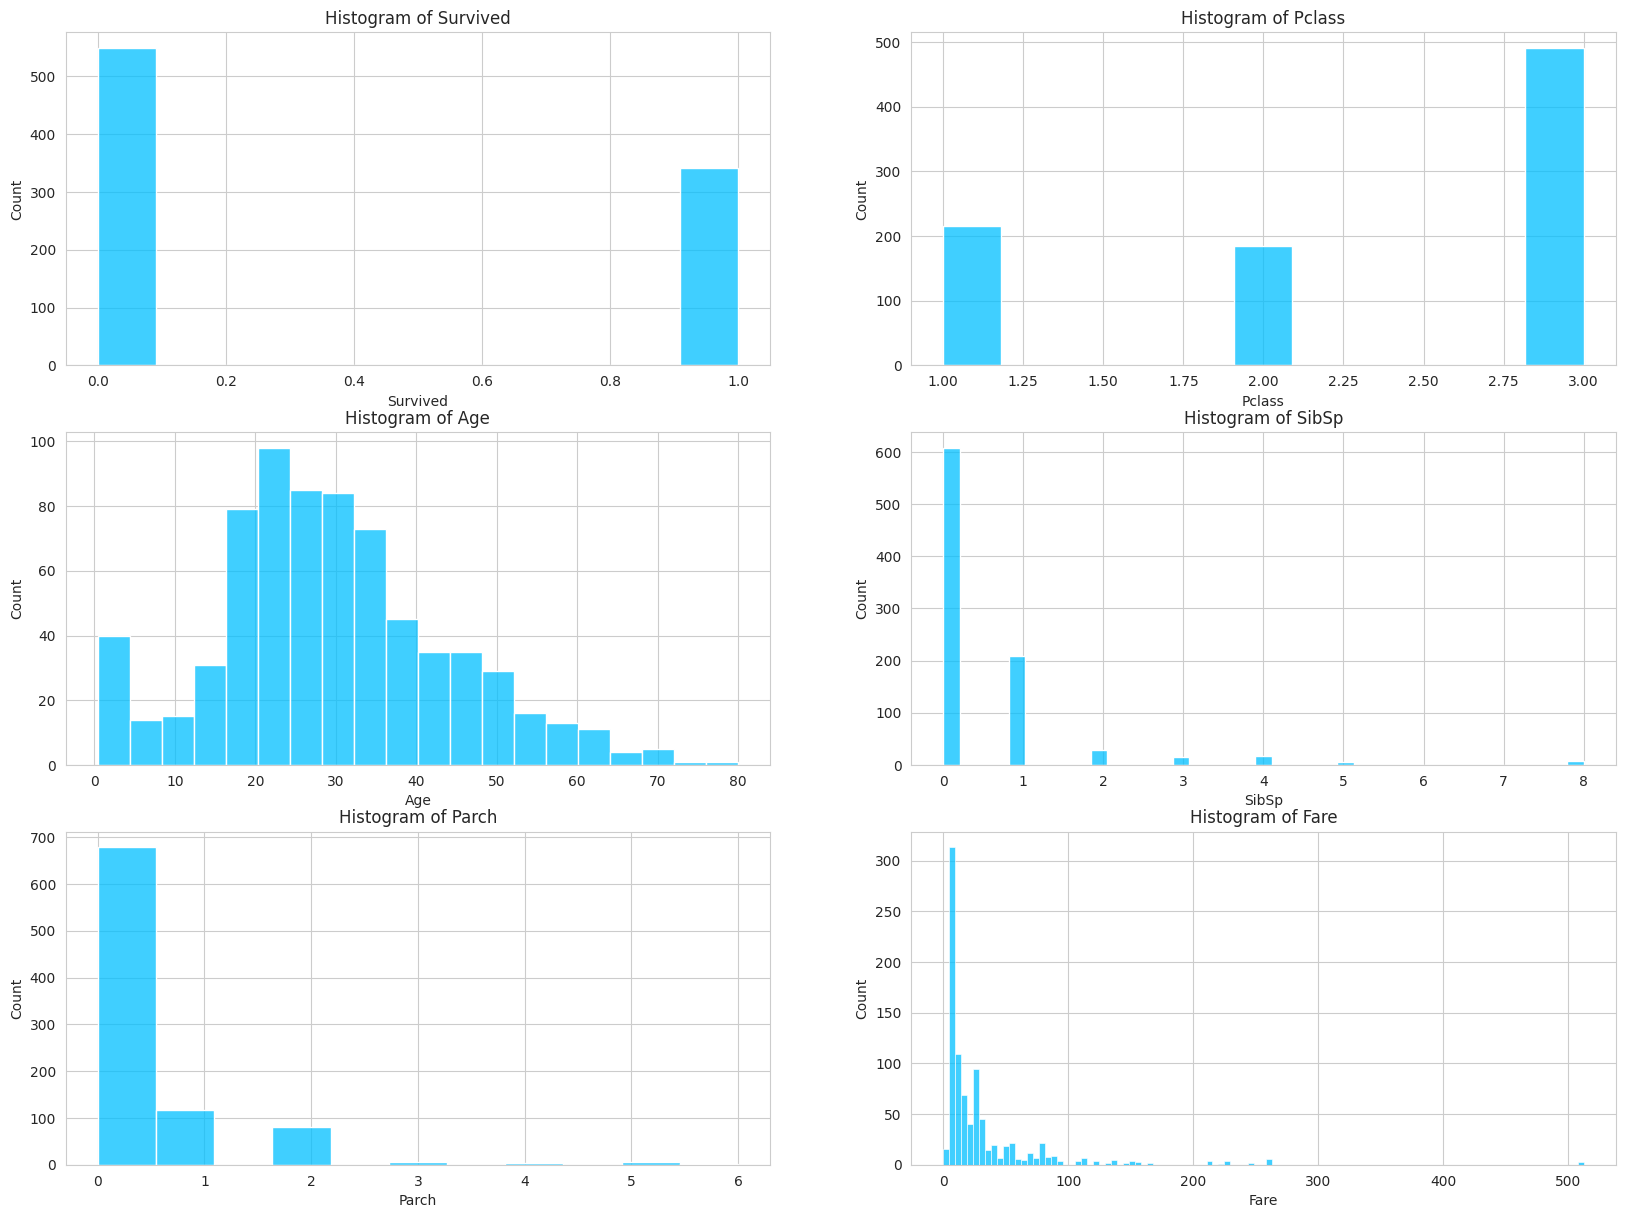

In [19]:
import seaborn as sns

# write function to visualize the distribution of variables
def plot_histograms(row,col,data,numerical_cols,color,title):
    fig,axes = plt.subplots(row,col,figsize=(20,15),dpi=100)
    i = 0
    for r in range(row):
        for c in range(col):
            try:
                sns.histplot(data=data[numerical_cols[i]],ax=axes[r,c],color=color)
                text_title = title + numerical_cols[i]
                i += 1
                axes[r,c].set_title(text_title)
            except IndexError:
                pass

# call the funciton
plot_histograms(3,2,data,numerical_cols,"deepskyblue","Histogram of ")

**Insights**:

- The distribution of Survived is obviously skewed, with people dying half more than that people surviving. If the dataset is imbalanced, then `stratify` needs to be used when splitting dataset so we can ensure the same percentage samples each target class as the complete set.
- Age has an approximately normal distirbution with slight positive skewness: the majority of passengers are aged between 20 and 40, and passengers who are 40 years or older are more than young people, who are less than 20 years old. We can examine the survival of young people.
- SibSp has eight unique values, but most of observations focus on 0, 1, and 2.
- Parch are mainly cemtered about 0, most of children travelling with only nanny. 
- Fare has severe positive skewness, with most of tickets priced from 10 to 30, and only very few passengers having fare higher than 100.

We filter out observations with higher than 100 fare, and examine any new information.

In [20]:
# let's extract these outliers to closely look at these outliers
f_mark = data["Fare"]>100
fare_data = data[f_mark]
fare_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,deck
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,3.0
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,2.0
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,3.0
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,2.0
195,196,1,1,"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,C,2.0


Here most of such passengers are at upper socio-economic status, from Cherbourg(France) and Southampton(British), and survived from the disaster. It seems like that the likelihood of survival is related to people's socio-economic status.

Make a bar chart to see the features of passengers spending a lot on fare.

In [21]:
fare_data.Pclass.value_counts()

1    53
Name: Pclass, dtype: int64

All of these passengers are from class 1. Now see the sex, age, survival.

In [22]:
fare_data.Sex.value_counts()

female    34
male      19
Name: Sex, dtype: int64

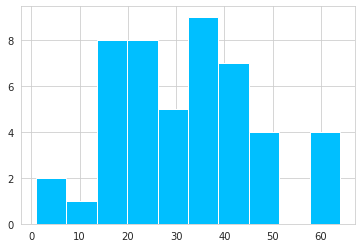

In [23]:
fare_data.Age.hist(color="deepskyblue")
plt.show()

**Insights:**

- Passengers with higher than 100 fare are basically aged between 15 and 45.


Here I proposed one assumption based on the finding and examine it in covariation section. 

**Assumption:**
- Passengers with higher socio-economic status are more likely to survive
- Pclass is associated with fare

### Typical Values

- For categorical variables, I plot bar chart to indicate the most frequently occurring categorty.
- For continuous variables, I first cut it into several data bins and then visualize them by bar charts.

In [24]:
# get discrete columns
discrete_cols = [column for column in numerical_cols if data_clean[column].nunique()<=15]
# combine together discrete columns and categorical columns
categorical_columns = [object_cols[1],object_cols[4]] + discrete_cols

Plot the distribution of these categorical variables

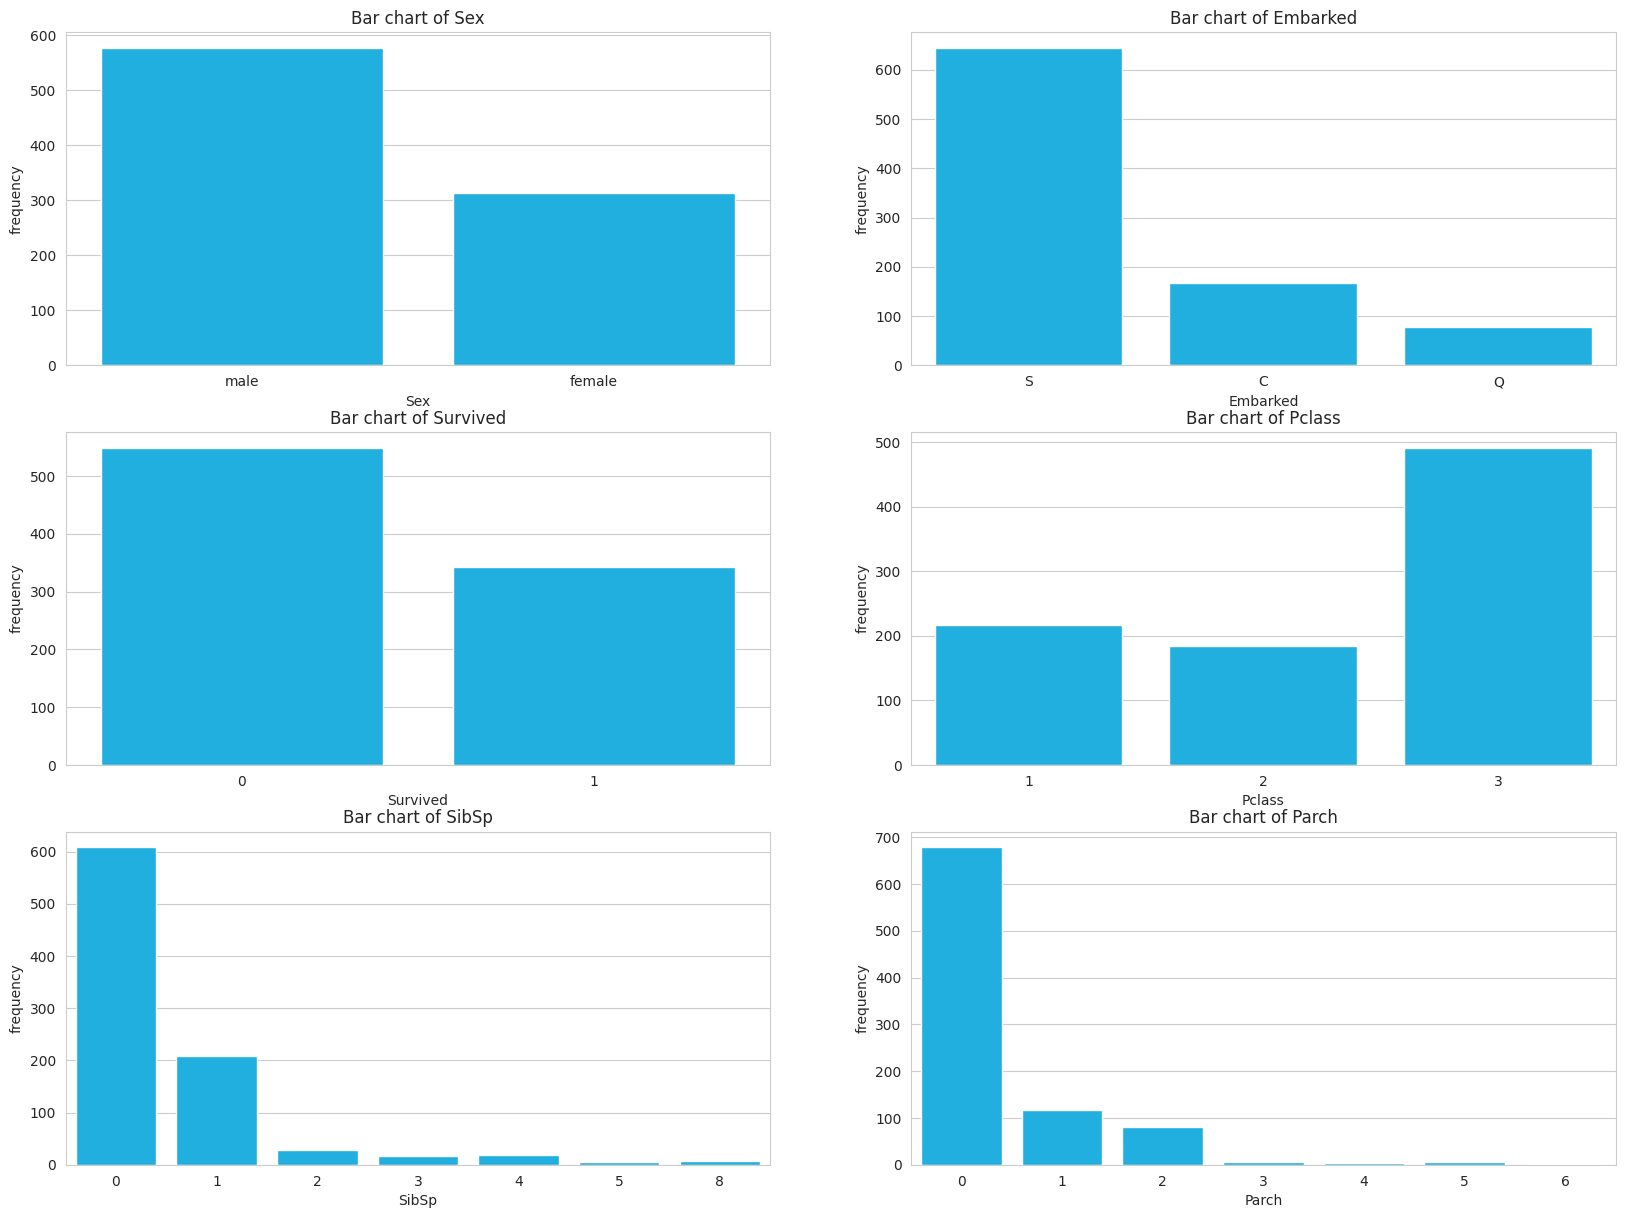

In [25]:
cat_data = data[categorical_columns]
i = 0
fig,axes = plt.subplots(3,2,figsize=(20,15),dpi=100)
for r in range(3):
    for c in range(2):        
        col = categorical_columns[i]
        try:
            freq_data = cat_data[col].value_counts().reset_index().rename(columns={"index":col,col:"frequency"})
            sns.barplot(data=freq_data,x=col,y="frequency",color="deepskyblue",ax=axes[r,c])
            axes[r,c].set_title("Bar chart of {}".format(col))
            i+=1
        except IndexError:
            pass
plt.show()

**Insights:**

- Male passengers are more than female passengers
- passengers mainly embarked from Southampton
- Most of pasengers died in the disaster
- Passengers in Titanic are mainly at low socio-economic status
- Most of children travel with their nanny instead of parents

Now let's take a look at the number of categories in each categorical variable. Note: if a categorical variable takes on more than 15 different values, one-hot encoding usually does not perform well on the variable. 

In [26]:
s = data_clean.dtypes == "object"
object_cols = data_clean.columns[s]
# Get number of unique entries in each column with categorical data
object_cols_ = discrete_cols+object_cols.tolist()
object_nunique = list(map(lambda col: data_clean[col].nunique(), object_cols_))
d = dict(zip(object_cols_, object_nunique))

# Print number of unique entries by column, in ascending order
sorted(d.items(), key=lambda x: x[1])

[('Survived', 2),
 ('Sex', 2),
 ('Pclass', 3),
 ('Embarked', 3),
 ('SibSp', 7),
 ('Parch', 7),
 ('Ticket', 681),
 ('Name', 891)]

Name, of course, is not related to our predictive modeling, and the unique values of Cabin and Ticket are way more than 15. So we will not apply **one-hot encoding** on them when processing them for machine learning algorithm. The two variables, I think, should be deleted.

In [27]:
data_clean = data_clean.drop(["Ticket"],axis=1)
data_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,9.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,9.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,9.0


### Outliers Checking

Perhaps some observations are remarkably different from others and these outliers can make machine learning algorithms hard to discover patterns behind data. We might need to consider dropping these oueliers due to logging errors.

#### Inspect the difference in fare by Sex

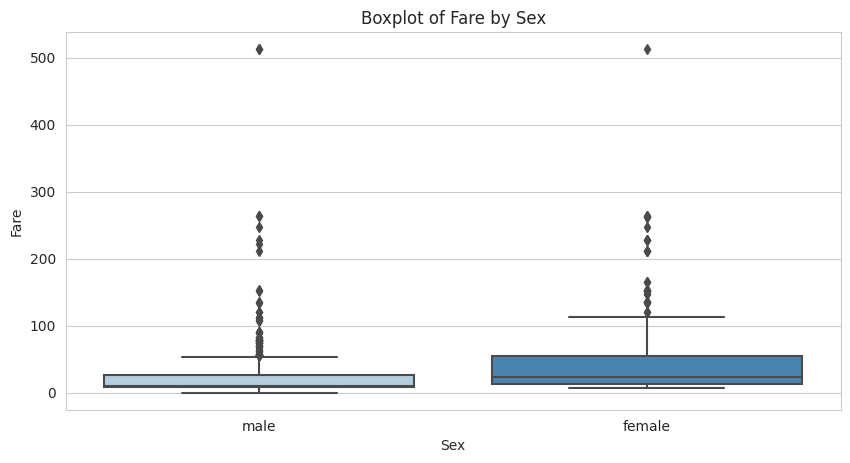

In [28]:
plt.figure(figsize=(10,5),dpi=100)
sns.boxplot(data=data,x="Sex",y="Fare",palette="Blues")
plt.title("Boxplot of Fare by Sex")
plt.show()

**Insights**:

- The median fare of female passengers is higher than that of male passengers.
- Male segment has more outlying observations than female segment, and more outliers can make mean value of male segment greater than that of female segment.

#### Inspect the difference in fare by Survived

Let's see whether survived passengers spend a lot more on Fare than passengers who failed to survive.

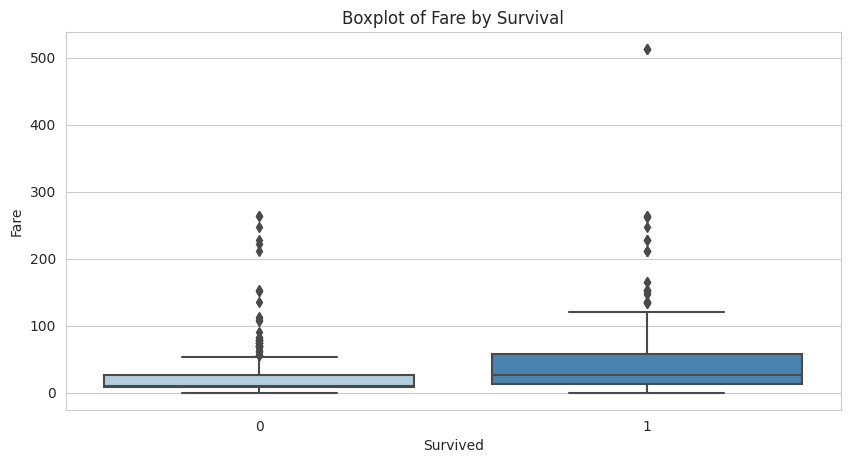

In [29]:
plt.figure(figsize=(10,5),dpi=100)
sns.boxplot(data=data,x="Survived",y="Fare",palette="Blues")
plt.title("Boxplot of Fare by Survival")
plt.show()

**Insights**:

- Obviously, passengers surviving in the disaster have higher fare than those dying.
- Of survived passengers, one passenger, which is a remarkable outlier, even spend more than 500 on fare.



## Covariation

I proposed an assumption in outliers section: survival of passengers is likely to be associated with socio-economic status. So the covariation description will address this issue and examine relationships between variables.

In [30]:
def get_columns(data):
    # extract cat columns
    s = data.dtypes == "object"
    object_cols = data.columns[s].tolist()

    # extract num columns
    n = (data.dtypes == "int64") | (data.dtypes == "float64")
    numerical_cols = data.columns[n].tolist()
    # drop target variable from numerical cols

    # find out discrete cols from numerical cols
    discrete_cols = [num_col for num_col in numerical_cols if data[num_col].nunique()<=15]
    return object_cols,numerical_cols,discrete_cols

object_cols,numerical_cols,discrete_cols = get_columns(data_clean)

### Age and Survial

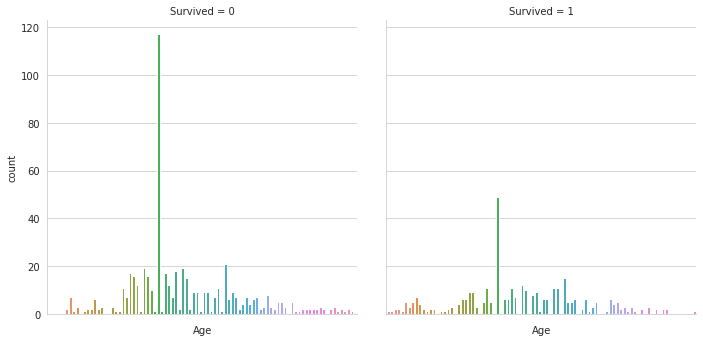

In [31]:
sns.catplot(data=data_clean,x="Age",col="Survived",kind="count")
plt.xticks(np.arange(data_clean["Age"].min(),data_clean["Age"].max(),10))
plt.show()

No remarkable patterns can be found when looking at survival from different ages.

### P-class and Survival

*Question: Whether people with high social status are more likley to survive?*

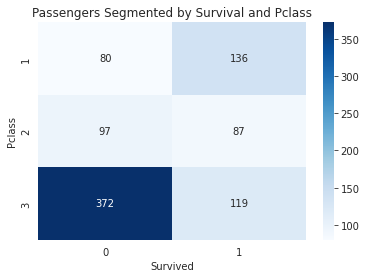

In [32]:
ctab = pd.crosstab(index=data_clean["Pclass"],columns=data_clean["Survived"])
sns.heatmap(ctab,annot=True,fmt="d",cmap="Blues")
plt.title("Passengers Segmented by Survival and Pclass")
plt.show()

**Insights:**

- For people who failed to survive, an obvious pattern can be found that powerful passengers are much less than people with low socio-economic status.
- For people who survived, the number of people with high status is still greater than people in other two pclasses.

The visualization helps to confirm the survival is related to people's economic status. A person's name may also contain informaiton about people's social status, such titles prefixing their name. Here I search the meaning of a variety of common titles on WikiPedia:

- *Master*. for boys and young men, or as a style for the heir to a Scottish peerage. It may also be used as a professional title, e.g. for the master of a college or the master of a merchant ship.
- *Mr* for men, regardless of marital status, who do not have another professional or academic title. The variant Mister, with the same pronunciation, is sometimes used to give jocular or offensive emphasis, or to address a man whose name is unknown.
- Miss: for girls, unmarried women and (in the UK) married women who continue to use their maiden name (although "Ms" is often preferred for the last two). In the UK, it has traditionally been used in schools to address female teachers, regardless of marital status. It is also used, without a name, to address girls or young women and (in the UK) to address female shop assistants and wait staff.
- Mrs:  for married women who do not have another professional or academic title, an abbreviation of Mistress. The variant Missus is used in the UK to address a woman whose name is unknown. There are examples of professional women who were unmarried using the title Mrs, such as Mrs Crocombe, the Cook at Audley End House in the late 19th century.

#### Name & Survival

Extract title from the name of passenegrs.

In [33]:
import re,string

def extract_title(full_name):
    """return title from full name"""
    given_name = full_name.split(",")[0]
    surname_full = full_name.split(",")[1].strip()
    title = surname_full.split(".")[0]
    surname = surname_full.split(".")[1].strip()
    return title


def replace_titles(x):
    title=x['title']
    if title in ['Don', "Dona",'Major', 'Capt', 'Jonkheer', 'Rev', 'Col',"Sir"]:
        return 'Mr'
    elif title in ['the Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms',"Lady"]:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
    
    
def create_title(data):
    title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',"Sir",'Dr',
                'Ms', 'Mlle','Col', 'Capt', 'Mme', 'the Countess','Don', 
                'Jonkheer',"Dona"]
    data["title"] = data["Name"].apply(lambda x:extract_title(x))
    data["title"] = data.apply(lambda row:replace_titles(row),axis=1)
    return data

In [34]:
data_clean = create_title(data_clean)
data_clean.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

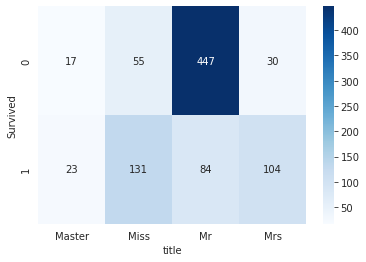

In [35]:
temp = pd.crosstab(index=data_clean["Survived"],columns=data_clean["title"]).reset_index().set_index("Survived")
sns.heatmap(temp,annot=True,fmt="d",cmap="Blues")
plt.show()

**Interpretation:**

- Passengers with Mr title mostly died in the disaster, only 15% of them survived, indicating that Male is more likley to die.
- Most of passengers with Mrs title survived from the the wreckage, almost 78%, suggesting that Passengers with Mrs have higher probability of survival.
- Approximatlely 70% of passengers with Miss title survived from the disaster.

**Summary**

Other than passengers with Mr title, passengers with other titles who survived are more than those dying.

#### Pclass and Age

Through missing checking, I have found that most of pasengers without age information center on class 3. So I decided to check the survival of passengers from class 1 and class 2 because most of they have full information.

*Question: What is the survival situation for passengers from class 1 and class2. Is age an influencer on the survival? Or Are young people more likely to survive or not?*

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


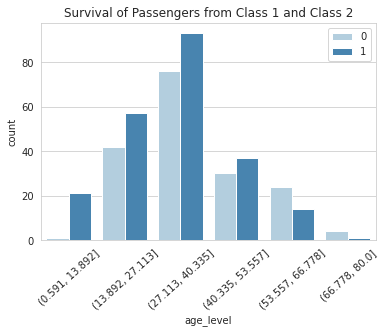

In [36]:
# extract data of passengers from clas 1 and class 2
mark = data_clean.Pclass != 3
data_class12 = data_clean[mark]

# split continuous age into 6 age bins
data_class12["age_level"] = pd.cut(data_class12.Age,6)

# visualize
temp = data_class12.groupby(["Survived","age_level"]).agg({"PassengerId":"count"}).reset_index().\
rename(columns={"PassengerId":"count"})
sns.barplot(data=temp,x="age_level",y="count",hue="Survived",palette="Blues")
plt.xticks(rotation=42)
plt.title("Survival of Passengers from Class 1 and Class 2")
plt.legend(loc="best")
plt.show()

**Interpretation:**

- Coming from class 1 and class 2, Passegers who are less than 14 years old basically all survived.
- For other age bands, no obvious patterns can be found via the graph.

The insight suggests that the survival of passengers are correlated with whether they are very young and from class 1 or class2. So I decided to create one variable to indicate the conditions.

In [37]:
data_clean["Is_class1_or_class2_age_less_than_14"] = ((data_clean["Pclass"] != 3) & (data_clean["Age"]<=14)).astype("int")

#### Pclass & SibSp

*Question: what is the survival rate for passengers in different classes and having spouses or siblings.*

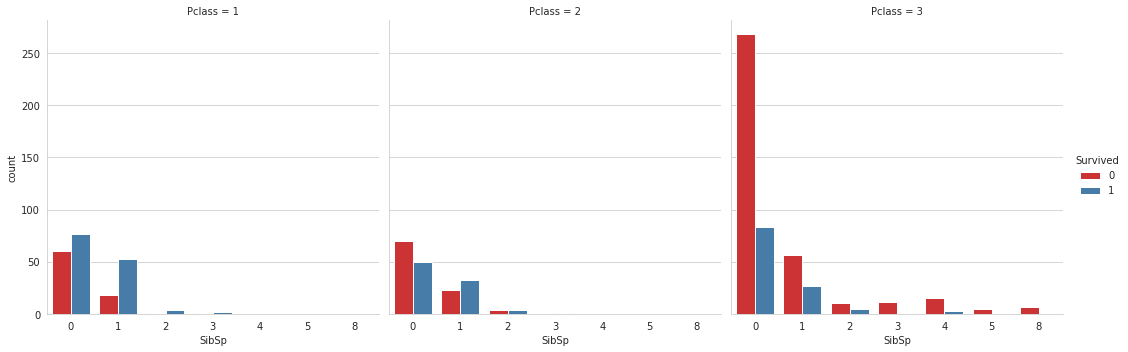

In [38]:
sns.catplot(data=data_clean,x="SibSp",col="Pclass",kind="count",hue='Survived',palette="Set1")
plt.show()

**Insights:**

- For passenger from class 1, those having no spouse/sibling are more likely to survive.
- For passenger from class 1, those having one spouse/sibling mostly survive.
- From class 3, lonely passengers are much more likley to die than passengers having one or more than one SibSP.

### Pclass & Embarked


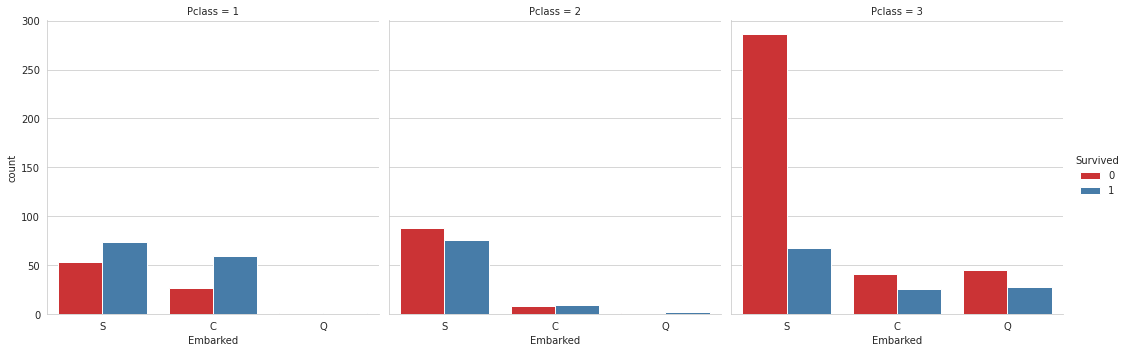

In [39]:
sns.catplot(data=data_clean,x="Embarked",col="Pclass",kind="count",hue='Survived',palette="Set1")
plt.show()

### SipSp & Survival

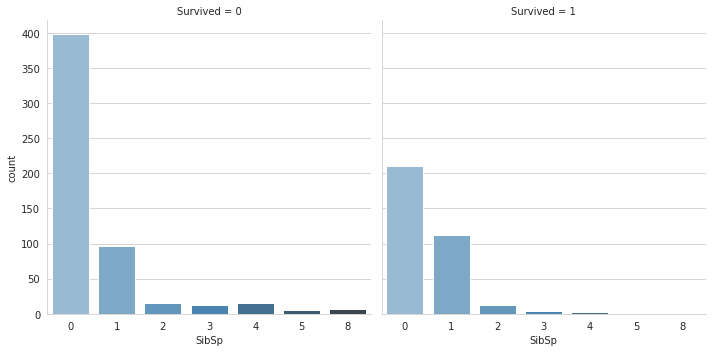

In [40]:
sns.catplot(data=data,x="SibSp",col="Survived",kind="count",palette="Blues_d")
plt.show()

**Insights:**

- In either segment, survival or die, most of passengers belong to the category of 0, indicating no association between SibSp and Survival. I will conduct feature selection to decide whether this variable should be included in model.

### Parch & Survival

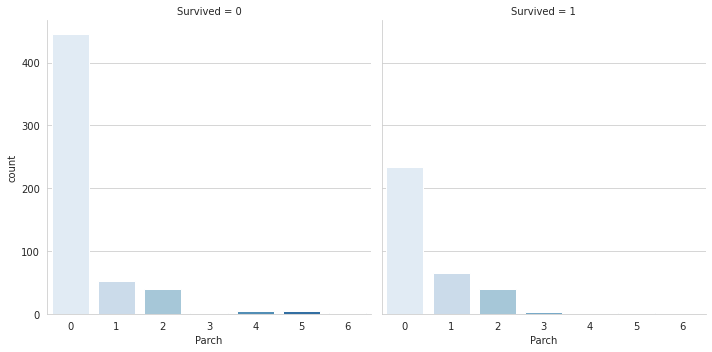

In [41]:
sns.catplot(data=data_clean,x="Parch",col="Survived",kind="count",palette="Blues")
plt.show()

No difference can be found between people who survived and people who failed to survive. Feature selection should be implemented to decide whether `Parch` should be included in model.

### Family Size & Survival

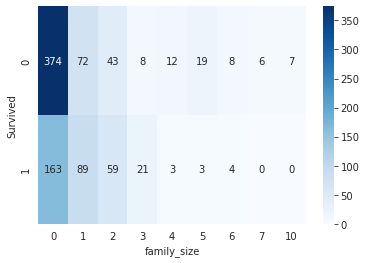

In [42]:
data_clean["family_size"] = data_clean["SibSp"] + data_clean["Parch"]
crosstab = pd.crosstab(index=data_clean['Survived'],columns=data_clean["family_size"])
sns.heatmap(crosstab,annot=True,fmt="d",cmap="Blues")
plt.show()

**Insight:**

- The difference between Survived and death narrows when the size of family increases, but the trend changes radically after size 3.
    - With no family members, most of passengers died
    - With one family member, the number of passenegrs perishing basically is equal to that of passengers surviving.
    - With two or three family members, number of people surviving surpasses that of people perishing.
- The number of people perishing begin to exceed that of people surviving when the size of family is greater than 0 but smaller or equal to 3.

**Therefore, the family size, to some extent, has some subtle relations with survival. I will add one variable to indicate whether the size of family is smallter than or equal to 3 but greater than 0**

In [43]:
data_clean["Is_family_size_less_than_3"] = ((data_clean["family_size"]<=3) & ((data_clean["family_size"]>0))).astype("int")

### Sex &  Survival

I segmented the data by sex and count the number of male passengers who survived and the quantity of female passengers who survived. 

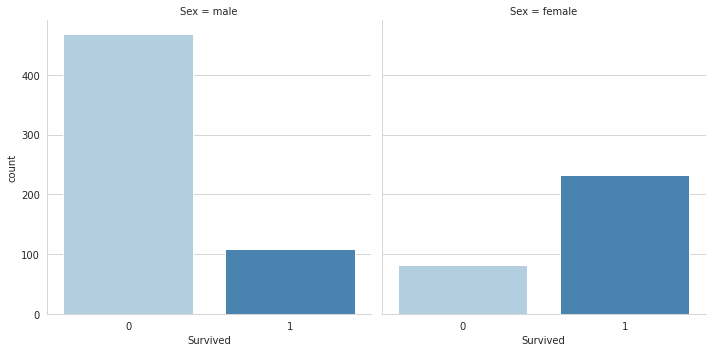

In [44]:
sns.catplot(data=data_clean,x="Survived",col="Sex",kind="count",palette="Blues")
plt.show()

**Interpretation:**

- For male passengers, most of them failed to survive
- For female passengers, survived passengers are more than those dying.
- Sex is a strong indicator of survival, meaning that Sex is a good feature that can help us to predict whether a passenger can survive from the disaster.

**I will encode sex variable from text to numbers, with female being 1 and male being 0, because female passengers are more likely to survive.**

In [45]:
data_clean["Sex"] = data_clean["Sex"].replace({"female":1,"male":0})

#### Sex & Pclass

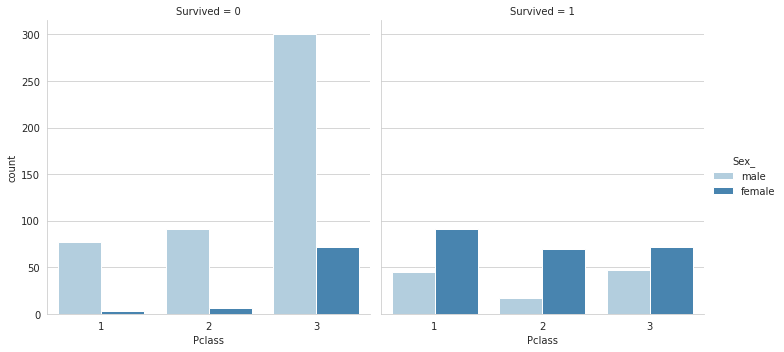

In [46]:
data_clean["Sex_"] =  data_clean["Sex"].replace({1:"female",0:"male"})
sns.catplot(data=data_clean,x="Pclass",col='Survived',kind="count",palette="Blues",hue="Sex_")

**Insights:**

- Passenger are extremely likely to perish if they are male and live in class 3.

### Fare and Pclass

***Hunch: fare is highly correlated with pclass.***

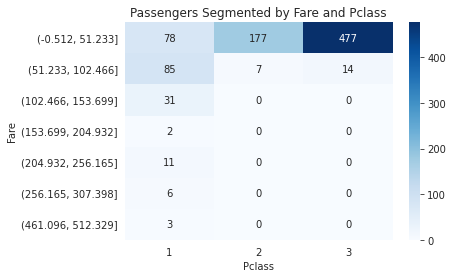

In [47]:
# cut fare into several data bins
ctab = pd.crosstab(pd.cut(data["Fare"],bins=10),data["Pclass"])
sns.heatmap(ctab,annot=True,fmt="d",cmap="Blues")
plt.title("Passengers Segmented by Fare and Pclass")
plt.show()

Passengers with low status are mainly centered around the range of (0,100), while only wealthy people can be found in bins of higher than 100. To some extent, the plot indicates the association between fare and pclass.

By missing values checking, I found `cabin`, `age`, and `Embarked` have observations being missing. Of these variables, `cabin` have more than 70% of observations being missing, so I will drop it. For `Age`, I decided to examine the relation between it and other variables to decide how to fill the missing information.

### Age Versus Fare

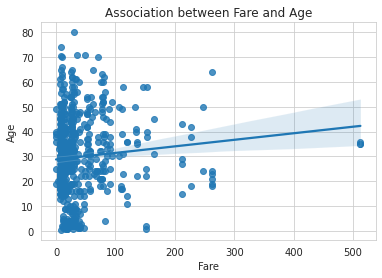

In [48]:
sns.regplot(data=data,x="Fare",y="Age")
plt.title('Association between Fare and Age')
plt.show()

**Interpretation:**

Young people tend to buy cheap tickets, while expensive tickets were bought by ederly people. But this plot cannot reveal any information about survival.

Now examine the relations between all variables.

Then we take a look at the correlation matrix of all variables to see the pair-wise relation.

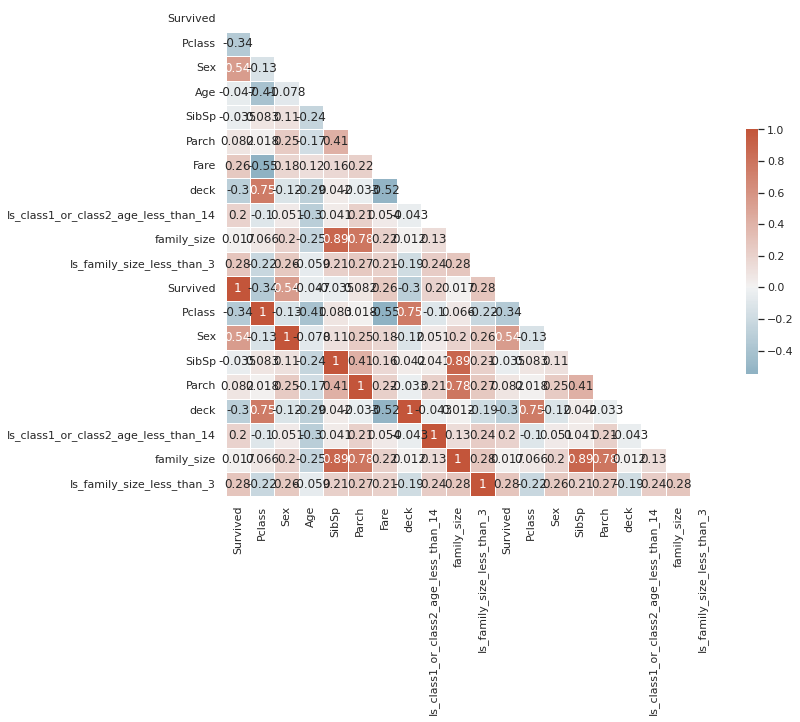

In [49]:
from string import ascii_letters

sns.set_theme(style="white")

# extract columns
obj,num,dis = get_columns(data_clean)

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = data_clean[num+dis].drop("PassengerId",axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

**Interpretation:**

- Sex is highly correlated with Survived, meaning that sex of passengers has huge impact on whether passengers can survive; In contrast, SibSp, Parch, and Age seemingly did not influence the survival of passengers. 
- Fare and Pclass is strongly correlated with each other, meaning that one of them does not provide additional new information for model if we keep them in models. So I will drop Fare from dataset.
- Age is negatively associated with Pclass, meaning that I can infer the missing age based on Pclass.
- The additional added variables, such as `Is_family_size_less_than_3`, is relatively correlated with survival.

**Summary**

- **Variation**
    - **Missing**
        - Cabin has more than 70% of observations being missing, and has as many as 147 unique values. So I will delete the variable.
        - Age and Embarked have much smaller proportion of missing values, so I decided to impute them with certain values.
    - **Distribution.** Most of variables have skewed distribution, including target variable. We have to use machine learning algorithms capable of handling with the situation to make accurate predictions.
    - **Outlier.** Fare has a number of outliers that can make machine learning algorithms hard to identify patterns from data.
- **Covariation**
    - Sex is a huge influencer on survial.
    - Pclass is correlated with fare, so fare will be deleted.
    - Age can be inferred by Pclass

# Data Preprocessing & Feature Engineering

- First, drop PassengerId and Name from dataset. 
- Then perform feature engineering on the dataset to process it so that we can implement machine learning algorithms.
- For title, as Mr and Mrs are strongly associated with sex so I drop it from dataset.

In [50]:
data_clean = data_clean.drop(["Name","PassengerId","Fare","SibSp","Parch","Sex_"],axis=1)

Convert Sex to binary variable

In [51]:
from sklearn.model_selection import train_test_split

# split data into features and label
X = data_clean.drop("Survived",axis=1)
y = data_clean["Survived"]

# then split data into train set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

X_train_full = X_train.copy()
X_test_full = X_test.copy()

(712, 9) (179, 9) (712,) (179,)


**Feature Engineering**

In [52]:
# import necessary packages
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [53]:
# imputer the missing info for Embarked
imputer = SimpleImputer(strategy="most_frequent")
X_train_full = pd.DataFrame(imputer.fit_transform(X_train_full),columns=X_train_full.columns)
X_test_full = pd.DataFrame(imputer.fit_transform(X_test_full),columns=X_test_full.columns)

# dummy variable
X_train_full = pd.get_dummies(X_train_full,columns=["Embarked","title"])
X_test_full = pd.get_dummies(X_test_full,columns=["Embarked","title"])

**Feature Scaling**

In [54]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_full = pd.DataFrame(scaler.fit_transform(X_train_full),columns=X_train_full.columns)
X_test_full = pd.DataFrame(scaler.fit_transform(X_test_full),columns=X_test_full.columns)

# Model Selection

I will test a range of classifiers to decide which one machine learning algorithm is worth GridSearching. And I will use roc_auc score as the core metric and cross validation to examine the performance of models.

Base machine learning algorithms include:
- Linear Models
    - Logistic Regression
    - Support Vector Machine
- K-Nearest Neighbors
- Naive Bayes
- Tree-based Models
    - Decision Tree Classifier
    - Random Forest
    - XGboost

In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_predict,cross_val_score

seed = 42

models = [
    ('kNN',KNeighborsClassifier()),
    ('SVC',SVC(random_state=seed, probability=True)),
    ('DT',DecisionTreeClassifier(random_state=seed)),
    ('RF',RandomForestClassifier(random_state=seed)),
    ('GB',GradientBoostingClassifier(random_state=seed)),
    ('GauNB',GaussianNB()),
    ('LR',LogisticRegression(solver='liblinear',max_iter=10000))
]

In [56]:
def fit_model(X,y,model,cv_fold,metric,plot=False):

    # Fit model on trains set
    model.fit(X,y)

    # Predict training set
    train_pred = model.predict(X)
    train_predprob = model.predict_proba(X)[:,1]

    # Cross-Validation
    cv_score = cross_val_score(model,X,y,cv=cv_fold,scoring=metric)
    cv_ypred = cross_val_predict(model,X,y,cv=cv_fold)

    # plot confusion matrix and roc_auc curve
    if plot:

        # print accuracy
        train_res = "Train Accuracy: {:.4f} | ".format(metrics.accuracy_score(y,train_pred))
        train_res += "Train AUC Score : {:.4f}\n".format(metrics.roc_auc_score(y,train_pred))
        train_res += "CV Score: Mean - {0}|std-{1}|Min-{2}|Max-{3}".\
        format(np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))


        # make visualization for prediction
        from sklearn.metrics import confusion_matrix
        fig,axes = plt.subplots(1,2,figsize=(16,5),dpi=100)
        fig.suptitle("{} Model Report".format(model))
        fig.text(0.5,0,train_res,ha="center",va="center")
        
        # confusion maxtrix
        confusion=metrics.confusion_matrix(y_true=y,y_pred=cv_ypred)
        sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d',ax=axes[0])
        axes[0].set_xlabel("highPunctuality_predictLogit")
        axes[0].set_ylabel("highPunctuality") 

        # roc_auc curve
        from sklearn.metrics import roc_curve
        fpr, tpr, thresholds = roc_curve(y, cv_ypred)
        axes[1].plot(fpr, tpr, label='ROC curve (area = %0.3f)' % np.mean(cv_score))
        axes[1].plot([0, 1], [0, 1], 'k--')  # random predictions curve
        axes[1].set_xlim([0.0, 1.0])
        axes[1].set_ylim([0.0, 1.0])
        axes[1].set_xlabel('False Positive Rate or (1 - Specifity)')
        axes[1].set_ylabel('True Positive Rate or (Sensitivity)')
        axes[1].set_title('Receiver Operating Characteristic')
        axes[1].legend(loc="lower right")
        
        print(train_res)
    
    return cv_score

In [57]:
# iterate all selected models
results = []
names = []
stats = []

for name,model in models:
    res = fit_model(X_train_full,y_train,model,10,"roc_auc")
    names.append(name)
    results.append(res)
    stats.append([np.mean(res),np.std(res)])

# dataframe 
scores = pd.DataFrame(stats,index=names,columns=["mean","std"])
scores = scores.sort_values(by="mean",ascending=False)
scores

,mean,std
LR,0.865768,0.040067
GB,0.863758,0.058395
kNN,0.859596,0.056372
SVC,0.859452,0.028246
GauNB,0.858441,0.050588
RF,0.839725,0.063748
DT,0.753035,0.075058


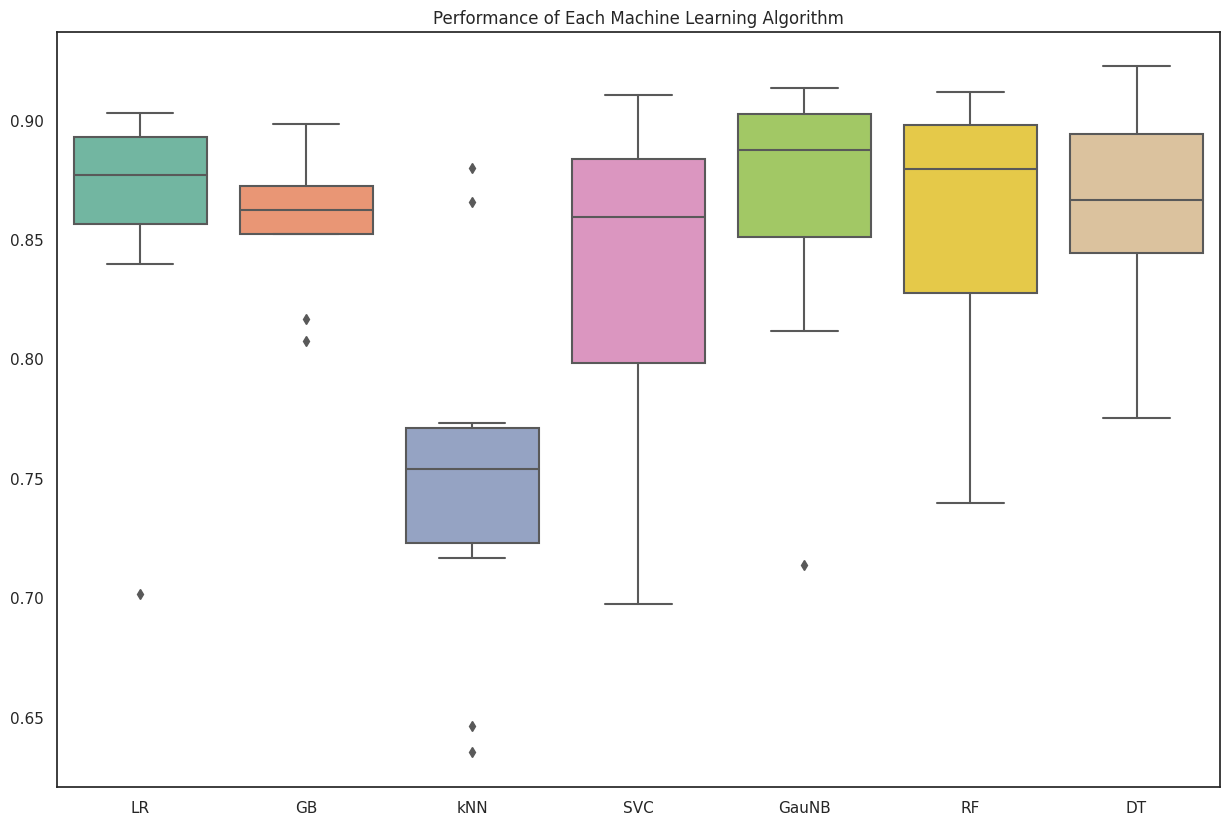

In [58]:
# visualize the scores of each model
fig,ax = plt.subplots(1,1,figsize=(15,10),dpi=100)
sns.boxplot(data=results,palette="Set2")
ax.set_xticklabels(scores.index)
ax.set_title("Performance of Each Machine Learning Algorithm")
plt.show()

Logistic regression have the highest roc_auc score, followed by GradientBoost Classifier. But the height of GB is much less than that of logistic regression. 

To determine which model performs best in the setting, I perform gridsearch to the two algorithms and use cross validation to compare them.

## Logistic Regression

The logistic regression performs best but has high variance. First I perform gridsearch on it and examine the train accuracy and test accuracy. 

Train Accuracy: 0.8329 | Train AUC Score : 0.8194
CV Score: Mean - 0.8658551880935601|std-0.04065457273419444|Min-0.7719155844155844|Max-0.9217171717171717


array([0.77191558, 0.89448052, 0.89493355, 0.84469697, 0.86784512,
       0.86321549, 0.84848485, 0.92171717, 0.84427609, 0.90698653])

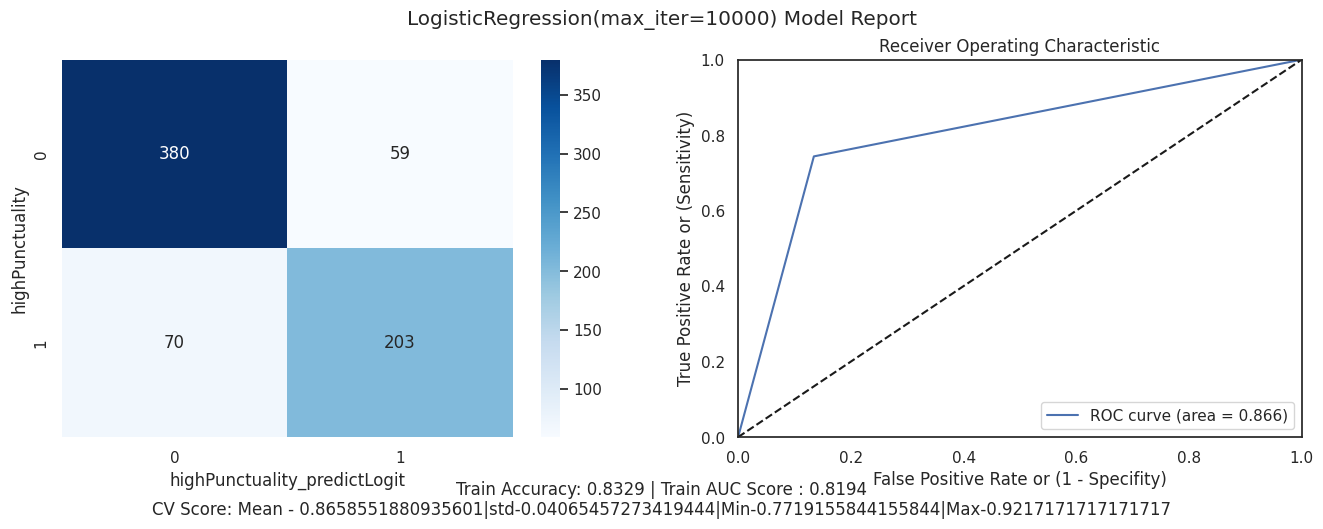

In [59]:
fit_model(X_train_full,y_train,LogisticRegression(max_iter=10000),10,"roc_auc",plot=True)

In [60]:
def cross_validation_eval(model,model_name,x,y,IsTrain=True):
    pred_lg =cross_val_score(model,x,y,cv=10,scoring="roc_auc")
    
    if IsTrain:
        print("Train Set Accuracy: ")
        print("----------------------------")
        print("{0}: {1}".format(model_name,round(pred_lg.mean(),3)))
    else:
        print("Test Set Accuracy: ")
        print("----------------------------")
        print("{0}: {1}".format(model_name,round(pred_lg.mean(),3)))
        
cross_validation_eval(LogisticRegression(max_iter=10000),"Logistic Regression",X_train_full,y_train)

Train Set Accuracy: 
----------------------------
Logistic Regression: 0.866


Train Accuracy: 0.8890 | Train AUC Score : 0.8699
CV Score: Mean - 0.8637584314909896|std-0.058394599349630025|Min-0.713474025974026|Max-0.9132996632996633


array([0.71347403, 0.90340909, 0.86918605, 0.84469697, 0.89183502,
       0.90782828, 0.8989899 , 0.91329966, 0.81144781, 0.88341751])

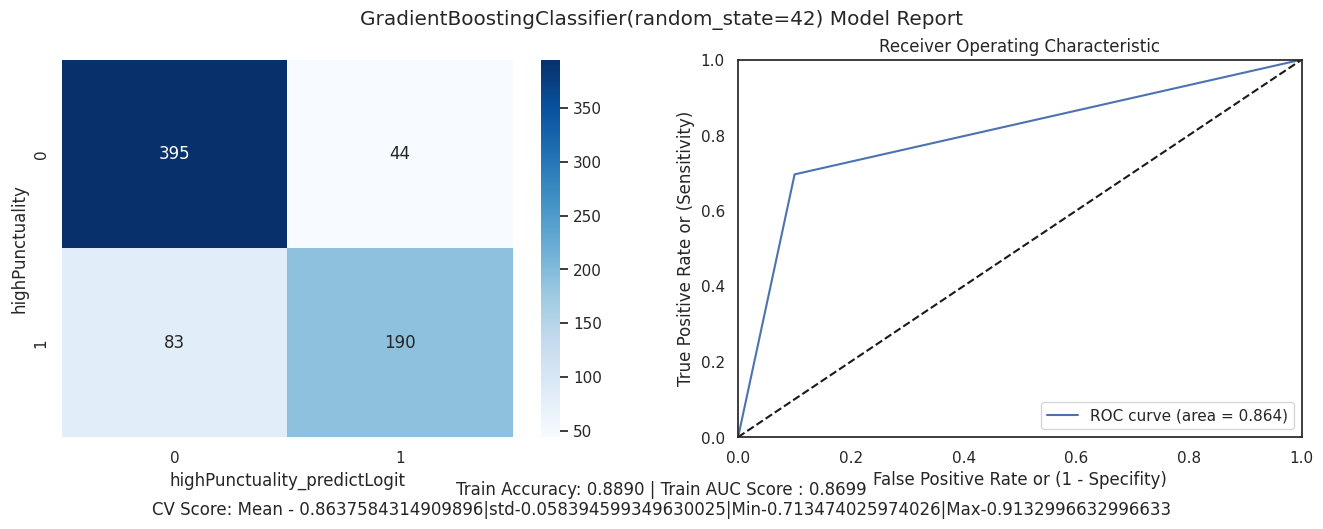

In [61]:
fit_model(X_train_full,y_train,GradientBoostingClassifier(random_state=42),10,"roc_auc",plot=True)

## Feature Selection

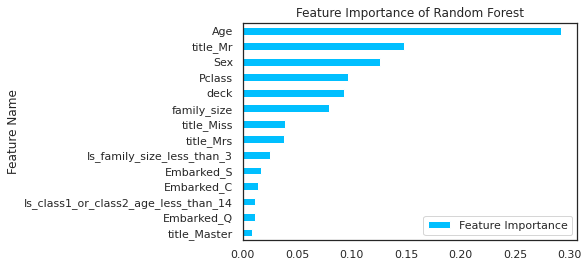

In [62]:
rf_clf = RandomForestClassifier().fit(X_train_full,y_train)
temp = pd.DataFrame({"Feature Name":X_train_full.columns,
              "Feature Importance":rf_clf.feature_importances_}).sort_values(by="Feature Importance")
temp.plot(x="Feature Name",y="Feature Importance",kind="barh",color="deepskyblue")
plt.title("Feature Importance of Random Forest")
plt.legend(loc="best")
plt.show()

### Correlation Coefficient

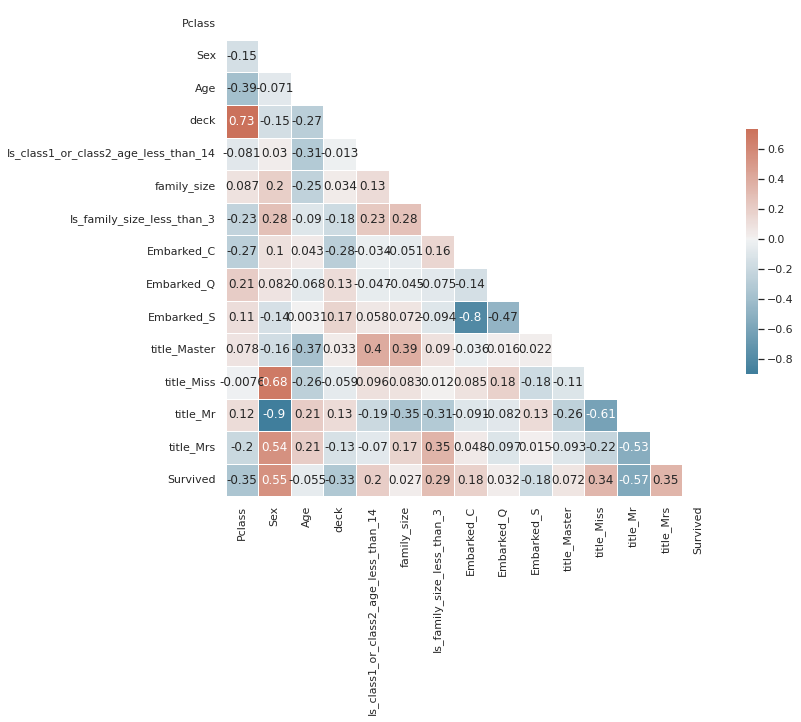

In [63]:
from string import ascii_letters

sns.set_theme(style="white")

corr = pd.concat([X_train_full,y_train.reset_index().drop("index",axis=1)],axis=1).corr()

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

From the result, we can find that `Age` is actually not correlated with Survival of passengers but has the highesy feature importance. So the result will be biased if we add `Age` in model. Therefore, I decided to drop `Age` from dataset and fit new models.

Also, `Embarked_Q` and `title_Master` have both low feature importance and not correlated with target variable. So the variable is also dropped from the dataset.

In [64]:
X_train_full_1 = X_train_full.drop(["Age","Embarked_Q","title_Master"],axis=1)
X_test_full_1 = X_test_full.drop(["Age","Embarked_Q","title_Master"],axis=1)

Fit models again.

Train Accuracy: 0.8216 | Train AUC Score : 0.8090
CV Score: Mean - 0.8670146229739253|std-0.04504815742450981|Min-0.7463474025974025|Max-0.9074074074074073


array([0.7463474 , 0.8924513 , 0.89119601, 0.85311448, 0.88468013,
       0.86111111, 0.89436027, 0.90740741, 0.84175084, 0.89772727])

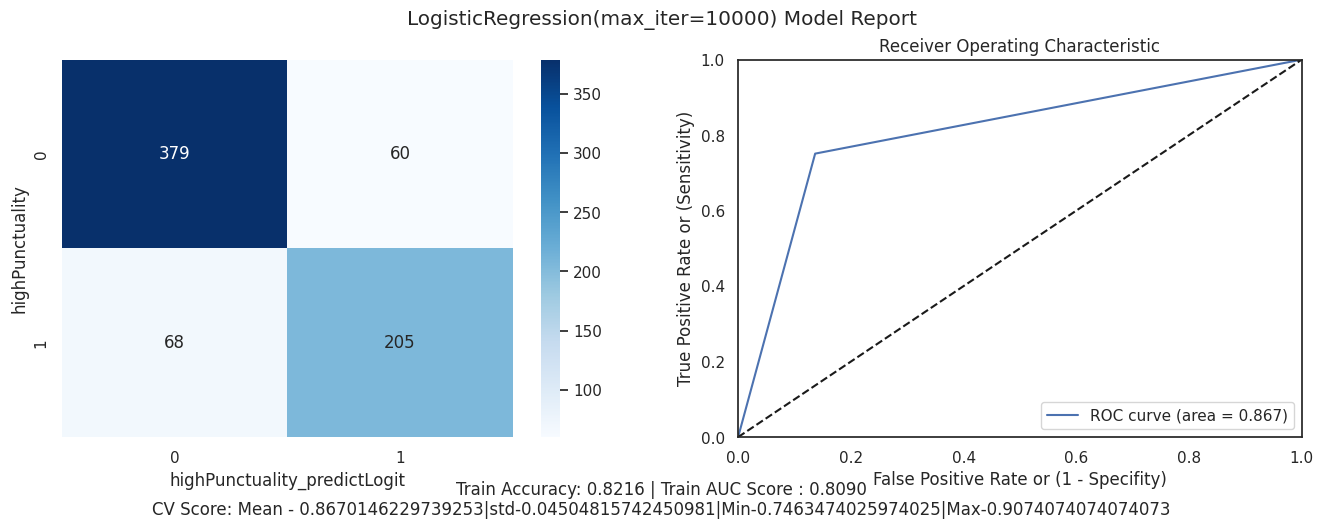

In [65]:
# logsitc
fit_model(X_train_full_1,y_train,LogisticRegression(max_iter=10000),10,"roc_auc",plot=True)

Train Accuracy: 0.8581 | Train AUC Score : 0.8386
CV Score: Mean - 0.8627904879358367|std-0.044221245405536444|Min-0.7739448051948052|Max-0.9048821548821548


array([0.77394481, 0.90219156, 0.89368771, 0.88047138, 0.87457912,
       0.89814815, 0.82154882, 0.90488215, 0.8013468 , 0.87710438])

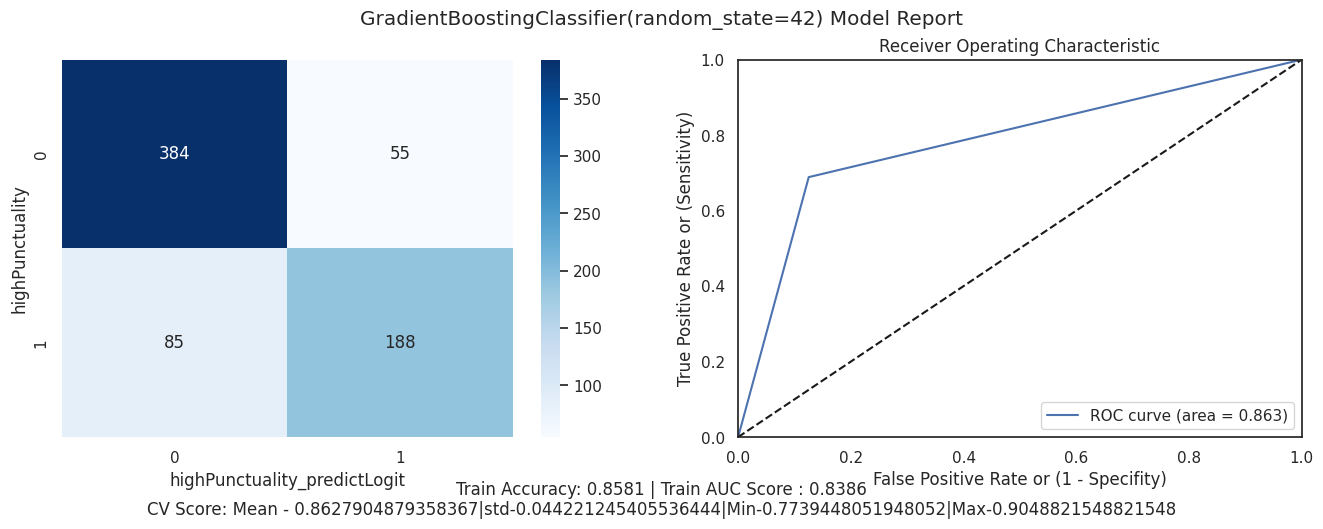

In [66]:
# Gradient Boost
fit_model(X_train_full_1,y_train,GradientBoostingClassifier(random_state=42),10,"roc_auc",plot=True)

The roc_auc scores of two models improve after `Age`, `Embarked_Q`, and `title_Master` are dropped.

## Grid Search

### Logistic Regression

In [67]:
from sklearn.model_selection import GridSearchCV

grid_test1 = {
    "max_iter":list(range(1000,11000,1000)),
    "solver":["liblinear","lbfgs","saga","sag"],
    "C":[0.01,0.05,0.06,0.07,0.09,0.1,1,10],
    "penalty":["l1","l2"]
}

lg_search1 = GridSearchCV(LogisticRegression(random_state=42),grid_test1,cv=10,verbose=0,scoring="roc_auc")
lg_search1.fit(X_train_full_1,y_train)

print(lg_search1.best_score_,lg_search1.best_params_)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for

0.8670146229739253 {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


Train Accuracy: 0.8216 | Train AUC Score : 0.8090
CV Score: Mean - 0.8670146229739253|std-0.04504815742450981|Min-0.7463474025974025|Max-0.9074074074074073


array([0.7463474 , 0.8924513 , 0.89119601, 0.85311448, 0.88468013,
       0.86111111, 0.89436027, 0.90740741, 0.84175084, 0.89772727])

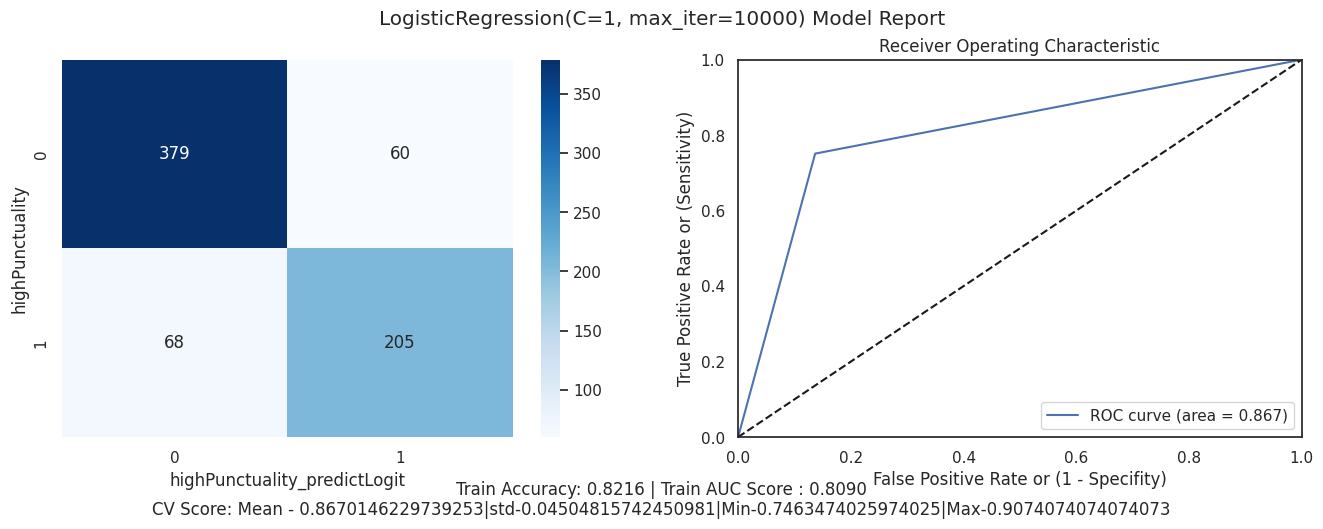

In [68]:
lg_rf = LogisticRegression(max_iter=10000,C=1,penalty="l2",solver="lbfgs")
fit_model(X_train_full_1,y_train,lg_rf,10,"roc_auc",plot=True)

GridSearch seems not to improve the model at all. I will fix the value of parameters.

Use test set to check the accuracy of model.

In [69]:
# Logistic Regression
cross_validation_eval(LogisticRegression(max_iter=10000,C=1,penalty="l2",solver="lbfgs"),
                     "Logistic Regression",X_test_full_1,y_test,IsTrain=False)

Test Set Accuracy: 
----------------------------
Logistic Regression: 0.868


**Finally, I decided to use Logistic Regression to make prediction.**

# Make Prediction Using Test Data

- Preprocess Test Data
- Logistic Regression
- Gradient Classifier

In [70]:
cwd = os.getcwd()
test_path = "../input/titanic/test.csv"
test_data = pd.read_csv(test_path)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Drop corresponding variables from dataset.

In [71]:
test_data["deck"] = test_data["Cabin"].str[0]
deck_normalized = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8}

def encode_cabin(df):
    df.replace({"deck": deck_normalized}, inplace=True)
    df['deck'].fillna(value=9, inplace=True)        

encode_cabin(test_data)

In [72]:
# drop a series of variables
test_data_clean = test_data.drop(["PassengerId","Cabin","Ticket","Fare"],axis=1)
test_data_clean["Sex"] = (test_data_clean["Sex"]=="female").astype("int")

- Create one variable to indicate whether the family size is greater than 0 but smallter or equal to 3.
- Create one variable to indictae whether the age of passengers is less than 14 and class of them is 1 or 2.

In [73]:
# expand 1
test_data_clean["Is_class1_or_class2_age_less_than_14"] = ((test_data_clean["Pclass"] != 3) & (test_data_clean["Age"]<=14)).astype("int")

# exapnd2
test_data_clean["family_size"] = test_data_clean["SibSp"] + test_data_clean["Parch"]
test_data_clean["Is_family_size_less_than_3"] = ((test_data_clean['family_size'] >0) & (test_data_clean["family_size"]<=3)).astype("int")

**Add one variable to represent the title of each passenger.**

In [74]:
test_data_clean = create_title(test_data_clean)
test_data_clean.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master'], dtype=object)

Drop `Name, SibSp, Parch, Age.`

In [75]:
test_data_clean = test_data_clean.drop(["Name","SibSp","Parch","Age"],axis=1)
test_data_clean = pd.get_dummies(test_data_clean,columns=["Embarked","title"])
# then scale the dataset
test_data_clean = pd.DataFrame(scaler.fit_transform(test_data_clean),columns=test_data_clean.columns)
# drop Embarked_Q
test_data_clean = test_data_clean.drop(["Embarked_Q","title_Master"],axis=1)

In [76]:
# concat train and test
X_full_data = pd.concat([X_train_full_1,X_test_full_1])
y_full_data = pd.concat([y_train,y_test])

## Logistic Regression Prediction using Test Data

In [77]:
# prediction
lg_rf_full = LogisticRegression(max_iter=10000,C=1,penalty="l2",solver="lbfgs").\
fit(X_full_data,y_full_data)
prediction_res = lg_rf_full.predict(test_data_clean)
prediction_res = pd.DataFrame({"PassengerId":test_data["PassengerId"],"Survived":prediction_res})
prediction_res = prediction_res.set_index("PassengerId")
prediction_res.to_csv("log_pred_res.csv")